In [1]:
import torch
import torchvision
import os
import tarfile
import torchvision.transforms as tt
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import sys
import errno

In [2]:
torch.cuda.is_available()

True

In [3]:
os.getcwd()

'/content'

In [4]:
# this is the main_folder of your code, the dataset and the models will be placed inside this folder
# by default this is the current folder, you can edit this to change the location of files
main_folder = os.getcwd()

#Download dataset in 'Cifar10' folder in your main_folder

In [5]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
#download the .tgz in the current directory
download_url(dataset_url, main_folder)

100%|██████████| 135M/135M [00:03<00:00, 42.6MB/s]


In [6]:
tarfile_path = main_folder + '/cifar10.tgz'

In [7]:
with tarfile.open(tarfile_path, 'r:gz') as tar:
    tar.extractall(path=main_folder) # this will create a cifar10 directory in your current folder

In [8]:
data_dir = main_folder + '/cifar10'
airplane_files = os.listdir(data_dir + "/train/airplane")
print("len=", len(airplane_files))
print(airplane_files[:5])

len= 5000
['3475.png', '0709.png', '1811.png', '0063.png', '3862.png']


In [9]:
dataset = ImageFolder(data_dir + "/train", transform = ToTensor())

In [10]:
img, label = dataset[0]
print(img.shape, label)
print(img)

torch.Size([3, 32, 32]) 0
tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235

we have images of 32x32 pixels and since it is a coloured image therefore we have 3 vectors for red, green and blue

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


in the above code the label comes out to be 0. this means that in the dataset.classes the zeroth index is the label

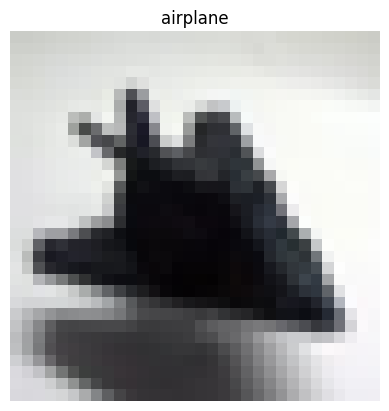

In [12]:
def show(img, label):
    plt.title(dataset.classes[label])
    plt.axis('off')
    plt.imshow(img.permute(1,2,0))

show(*dataset[0])

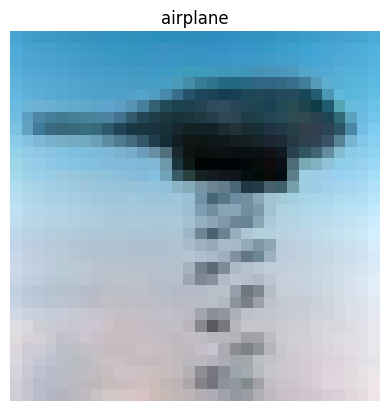

In [13]:
show(*dataset[304])

# Using GPU

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [15]:
device = get_default_device()
print(device)

cuda


# Normalization

1. We will normalize the image tensors by subtracting the mean and dividing by the standard deviation across each channel. As a result the mean of the data across each channel is 0 and standard deviation is 1. normalizing the data prevents the values from any one channel from disproportionately affecting the losses and gradients while training simply by having a higher or wider range of values that others.

2. We will apply randomly chosen transformation while loading from the training dataset. Specifically we will pad each image by 4 pixels and then take a random crop of size 32x32 pixels and then flip the image horizontally with 50% probability. Since the transformation will be applied randomly and dynamically each time a particualr image is loaded the model sees slightly different images in each epoch of training which allows it generalize better.

## Data transform (normalization and data augmentation)

In [16]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*stats)])
valid_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

In [17]:
class LazyDataset(Dataset):
    def __init__(self, dataset, transform = None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y

    def __len__(self):
        return len(self.dataset)

# Function to split the dataset into the validation set and the training set

In [18]:
train_dataset = ImageFolder(data_dir+'/train')
train_ds = LazyDataset(train_dataset, train_tfms)
val_ds = LazyDataset(train_dataset, valid_tfms)
test_ds = ImageFolder(data_dir+'/test', valid_tfms)

In [19]:
def split_indx(n, val_frct):
    n_val = int(n*val_frct)   # no. of images x faction
    idx = np.random.permutation(n)   # creating random permutation of 0 to n-1
    return idx[n_val:], idx[:n_val]

In [20]:
val_pct = 0.2

train_indices, val_indices = split_indx(len(train_dataset), val_pct)
print(len(train_indices), len(val_indices))

40000 10000


# Creating batches of training and validation set

In [21]:
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(train_ds, 100, train_sampler, num_workers=8, pin_memory=True)

val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(val_ds, 100, val_sampler, num_workers=8, pin_memory=True)

test_dl = DataLoader(test_ds, 100, shuffle=True, num_workers=8, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


we can look at the batches of images from the dataset using the make_grid method from torchvision. each time the following code is run, we get a different batch, since the smapler shuffles the indices before creating batches

In [22]:
def show(dl):
    for images, _ in dl:
        fig, ax = plt.subplots(figsize=(10,10))  # (10,10) is the figure size
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1,2,0))
        break

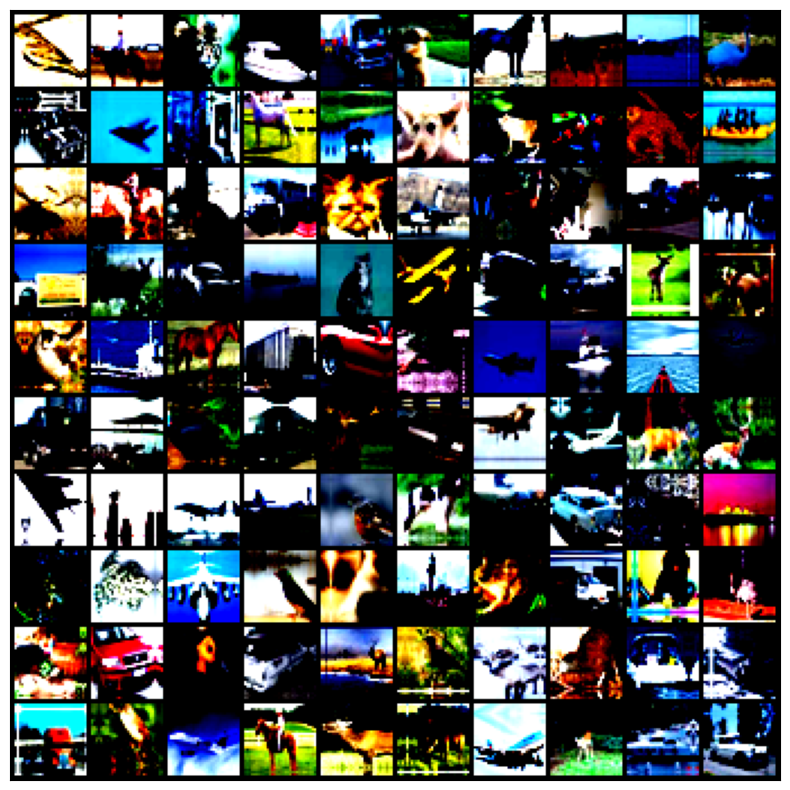

In [23]:
show(train_dl)

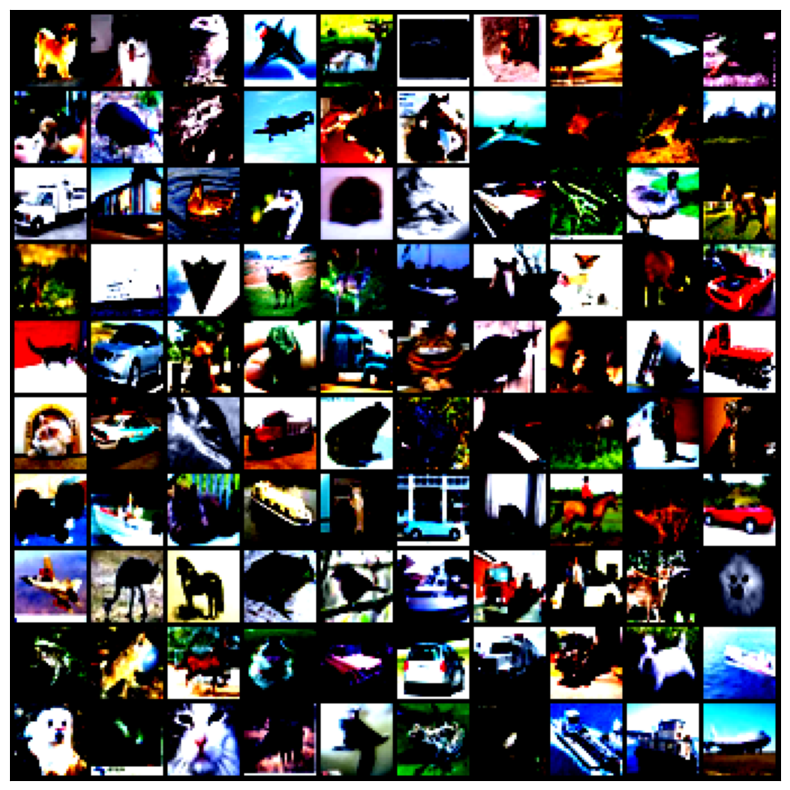

In [24]:
show(val_dl)

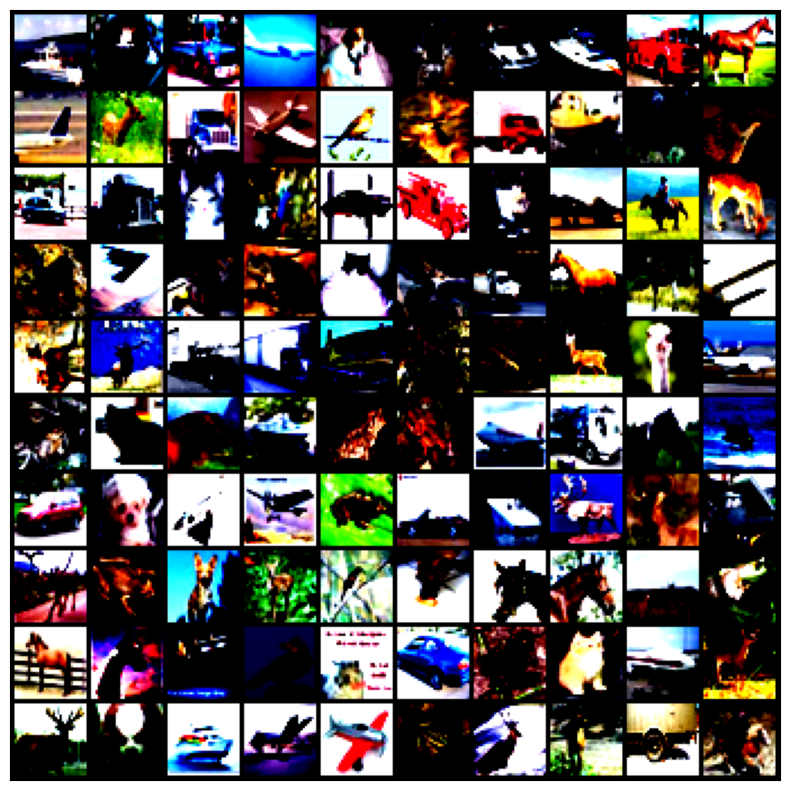

In [25]:
show(test_dl)

# Model with Residual Blocks and Batch Normalization

We'll use a significantly large model, called the WideResNet22 which has 22 convolutional layers. However one of the key changes to our model is the addition of the residual block to the output feature map obtained by passing the input through one or more convolutional layers

In [26]:
def conv_2d(ni, nf, stride=1, ks=3):
    # torch.nn.Conv2d(in_channels = n, out_channels = m, kernel_size = k, stride = s, padding = p)
    return nn.Conv2d(ni, nf, ks, stride, ks//2, bias=False)

def bn_relu_conv(ni, nf):
    return nn.Sequential(nn.BatchNorm2d(ni), nn.ReLU(inplace=True), conv_2d(ni, nf))
# nn. Sequential is a construction which is used when you want to run certain layers sequentially.
# It makes the forward to be readable and compact.

class ResidualBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):   # ni = no. of input channels, nf = no. of output channels
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, stride)
        self.conv2 = bn_relu_conv(nf, nf)
        self.shortcut = lambda x: x
        if ni!=nf:
            self.shortcut = conv_2d(ni, nf, stride, 1)

    def forward(self, x):
        x = F.relu(self.bn(x), inplace=True)
        r = self.shortcut(x)
        x = self.conv1(x)
        x = self.conv2(x) * 0.2
        return x.add_(r)

In [27]:
def make_group(N, ni, nf, stride):
    start = ResidualBlock(ni, nf, stride)
    rest = [ResidualBlock(nf, nf) for j in range(1,N)]
    return [start] + rest

class Flatten(nn.Module):
    def __init__(self): super().__init__()
    def forward(self, x):
        return x.view(x.size(0), -1)

class WideResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=16):
        super().__init__()
        layers = [conv_2d(3, n_start)]
        n_channels = [n_start]

        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            layers += make_group(N, n_channels[i], n_channels[i+1], stride)

        layers += [nn.BatchNorm2d(n_channels[3]),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   Flatten(),
                   nn.Linear(n_channels[3], n_classes)]

        self.features = nn.Sequential(*layers)

    def forward(self, x):
        return self.features(x)

def wrn_22():
    return WideResNet(3, N=3, n_classes=10, k=6)

In [28]:
model = wrn_22()

In [29]:
for images, labels in train_dl:
    print('iamges.shape=', images.shape)
    out = model(images)
    print('out.shape=', out.shape)
    break

iamges.shape= torch.Size([100, 3, 32, 32])
out.shape= torch.Size([100, 10])


# Training the Model

In [30]:
def loss_batch(model, loss_fn, xb, yb, opt=None, metric=None, schedular=None):
    preds = model(xb)
    loss = loss_fn(preds, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    if schedular is not None:
        schedular.step()

    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)

    return loss.item(), len(xb), metric_result

In [31]:
def evaluation(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrix = zip(*results)
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metrix = None
        if metric is not None:
            avg_metrix = np.sum(np.multiply(metrix, nums))/total
        return avg_loss, total, avg_metrix

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, best_model_path='trained_model.pth', every_epoch_path='model_epoch_{}.pth'):
        """
        Args:
            patience (int): Number of epochs to wait for improvement before stopping.
            delta (float): Minimum change to qualify as an improvement.
            best_model_path (str): Path to save the best model (lowest validation loss).
            every_epoch_path (str): Path to save the model at each epoch (includes epoch number).
        """
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_wts = None
        self.best_model_path = best_model_path
        self.every_epoch_path = every_epoch_path

    def __call__(self, val_loss, model, epoch):
        # Save the best model based on validation loss
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_wts = model.state_dict()
            torch.save(model.state_dict(), self.best_model_path)  # Save the best model
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.best_model_wts = model.state_dict()
            self.counter = 0  # Reset counter since we found an improvement
            torch.save(model.state_dict(), self.best_model_path)  # Save the best model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True  # Trigger early stopping
        return self.early_stop

In [33]:
early_stopping = EarlyStopping(patience=5, delta=0.001, best_model_path= main_folder + '/models/best_model.pt', every_epoch_path=main_folder + '/models/model_epoch_{}.pt')

In [ ]:
from tqdm import tqdm

def fit(epochs, model, loss_fn, train_dl, valid_dl, opt = None, lr=None, metric=None, schedular=None):
    train_losses, val_losses, val_metrix = [], [], []

    if opt is None:
        opt = torch.optim.SGD
    opt = opt(model.parameters(), lr)

    if schedular is not None:
        schedular = schedular(opt, [30], 0.3)

    best_val_loss = 100
    for i in range(epochs):
        model.train()
        for xb, yb in tqdm(train_dl, desc=f"training epoch {i}"):
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt, schedular=schedular)

        model.eval()
        result = evaluation(model, loss_fn, valid_dl, metric)
        val_loss, total, val_met = result
        model_path = os.path.join(main_folder,  'models' )
        if not os.path.exists( model_path ):
            os.makedirs(model_path)
        if early_stopping(val_loss.item(), model, i):
            print("Early stopping triggered!")
            model.load_state_dict(early_stopping.best_model_wts)  # Load the best model
            break

        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #torch.save(model.state_dict(), model_path + 'best_model.pt' )

        #torch.save(model.state_dict(), model_path + 'model_current.pt')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrix.append(val_met)

        if metric is None:
            print("epoch [", i+1, ',', epochs, '] , loss= ', val_loss)
        else:
            print('*Epoch [', i+1, ',', epochs, '], loss= ', val_loss, ',', metric.__name__, ':' , val_met)

    torch.save(model.state_dict(), model_path + 'trained_model.pt' )
    return train_losses, val_losses, val_metrix

In [35]:
def accuracy(outputs, lables):
    prob, preds = torch.max(outputs, dim = 1)
    return torch.sum(preds == lables).item()/len(preds)

In [36]:
def predict(ing, model):
    # convert to a batch of 1
    xb = img.unsqueeze(0)
    yb = model(xb.to(device))
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

WideResNet(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ResidualBlock(
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (shortcut): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (2): ResidualBlock(
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [38]:
opt = torch.optim.Adam
schedular = torch.optim.lr_scheduler.MultiStepLR
lr = 0.01
train_losses, val_losses, val_metrix = fit(4, model, F.cross_entropy, train_dl, val_dl, opt, lr, accuracy, schedular)

training epoch 0: 100%|██████████| 500/500 [01:25<00:00,  5.83it/s]


*Epoch [ 1 , 4 ], loss=  1.6134566025733947 , accuracy : 0.39588


training epoch 1: 100%|██████████| 500/500 [01:26<00:00,  5.77it/s]


*Epoch [ 2 , 4 ], loss=  1.369568621635437 , accuracy : 0.50454


training epoch 2: 100%|██████████| 500/500 [01:27<00:00,  5.69it/s]


*Epoch [ 3 , 4 ], loss=  1.165869432926178 , accuracy : 0.56916


training epoch 3: 100%|██████████| 500/500 [01:28<00:00,  5.65it/s]


*Epoch [ 4 , 4 ], loss=  0.9146809684038162 , accuracy : 0.67568


In [39]:
from sklearn import metrics
import torch
from tqdm import tqdm

model = wrn_22()
model_path = main_folder + '/models/'
model.load_state_dict(torch.load(model_path + 'best_model.pt'))
model.to(device)

test_dl = DeviceDataLoader(test_dl, device)
preds, labels = [], []
model.eval()
for x, y in tqdm(test_dl, desc="testing"):
    with torch.no_grad():
        output = model(x)
        pred = torch.argmax(output, dim=1)
    preds += list(pred.detach().cpu().numpy())
    labels += list(y.detach().cpu().numpy())

testing:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
testing: 100%|██████████| 100/100 [00:06<00:00, 15.37it/s]


In [40]:
# To calculate precision and recall for multilabel classification
# for each entry we need to create an array, say if a prediction is of class 1
# then it should be [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
labels_mat = []
preds_mat = []
for i in range( len(labels) ):
    l = labels[i]
    label_arr = np.zeros(10)
    label_arr[l] = 1
    labels_mat.append(label_arr)
    p = preds[i]
    pred_arr = np.zeros(10)
    pred_arr[p] = 1
    preds_mat.append(pred_arr)
labels_mat = np.array(label_mat)
preds_mat = np.array(preds_mat)

NameError: name 'label_mat' is not defined

In [ ]:
accuracy = metrics.accuracy_score(labels_mat, preds_mat)
precision = metrics.precision_score(labels_mat, preds_mat, average='samples')
recall = metrics.recall_score(labels_mat, preds_mat, average='samples')
confusion_matrix = metrics.confusion_matrix(labels, preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=dataset.classes)

print("precision = ", precision)
print("recall = ", recall)
print("accuracy = ", accuracy)

cm_display.plot()
plt.show()

In [ ]:
class SingleImageDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image = plt.imread(image_path)  # Open the image
        self.transform = transform
        self.classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    def __len__(self):
        return 1  # Since we only have one image

    def __getitem__(self, idx):
        # Return the image and the corresponding label (if available)
        if self.transform:
            image = self.transform(self.image)  # Apply transformations if provided
        else:
            image = self.image

        return image

In [ ]:
def evaluate(image_path):
    model = wrn_22()
    dataset = SingleImageDataset(image_path, transform=valid_tfms)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

    model_path = os.path.join( main_folder, 'best_model.pt' )
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)
    model.eval()
    for x in dataloader:
        with torch.no_grad():
            output = model(x)
        pred = torch.argmax(output, dim=1)
    return dataset.classes[pred[0].item()]
